## Exploratory data analysis of CTA ridership data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpld3

In [2]:
filename = "data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv"
df = pd.read_csv(filename)

In [3]:
# check for missing data, if any
if df.isna().values.sum():
    df.dropna(inplace=True)

In [4]:
# change date to datetime format
df['datetime'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [5]:
# extract season, day of week, month, year
seasons = ['Winter','Winter','Spring','Spring','Spring','Summer',
           'Summer','Summer','Fall','Fall','Fall','Winter']
months = range(1,13)
mtos = dict(zip(months,seasons))
df['season'] = df['datetime'].dt.month.map(mtos)
df['weekday']=df['datetime'].dt.dayofweek.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 
                                               3:'Thursday',
                                              4:'Friday', 5:'Saturday', 6:'Sunday'})
df['month']=pd.DatetimeIndex(df['datetime']).month
df['year']=pd.DatetimeIndex(df['datetime']).year

In [6]:
daytypes = df.daytype.unique().tolist()
daytypedict = dict(zip(daytypes, ['Sun/Hol', 'Weekday', 'Sat']))
df['daytype']=df['daytype'].map(daytypedict)

In [7]:
stations = df.stationname.unique().tolist()
mparklist = ['Washington/Wabash', 'Clark/Lake']

In [8]:
# check out when stations with least # days open
count_days = df.groupby('stationname')['rides'].count().reset_index()
day_count_stats = count_days.describe().loc['25%','rides']
count_days[count_days['rides'] < day_count_stats].sort_values(
    by='rides').reset_index(drop=True).loc[0:9]

,stationname,rides
0,Homan,31
1,Washington/Wabash,334
2,Cermak-McCormick Place,1277
3,Morgan-Lake,2252
4,Dempster-Skokie,2282
5,Oakton-Skokie,2282
6,Washington/State,2953
7,Skokie,4111
8,Madison/Wabash,6216
9,Conservatory,6239


In [9]:
# find trends in ridership (from 2012 to 2017 years)
years_list = np.arange(2017, 2011, -5)
df_diff = df[df['year'].isin(years_list)]
df_diff = df_diff.groupby(['stationname','year'])['rides'].mean().reset_index()

# get rid of stations w/ missing data in 2012 or 2017
df_diff = df_diff.groupby('stationname').filter(lambda x: len(x) >1)

# find change in ridership in past 5 years
df_diff['5yr_diff'] = df_diff['rides'].diff()
df_diff['5yr_percent_diff'] = df_diff['rides'].pct_change()
df_diff = df_diff[df_diff['year']!= 2012]

In [10]:
# get 25 stations with biggest ridership change from 5 years ago
topdiffs = df_diff.sort_values(by=['5yr_diff'], ascending=False
                              ).reset_index(drop=True).loc[0:10,:]
topprops = df_diff.sort_values(by=['5yr_percent_diff'], ascending=False
                              ).reset_index(drop=True).loc[0:10,:]
top = topdiffs[topdiffs['stationname'].isin(topprops['stationname'])]
topstationlist = top.stationname.unique()

Text(0, 0.5, '% Change 2012-2017')

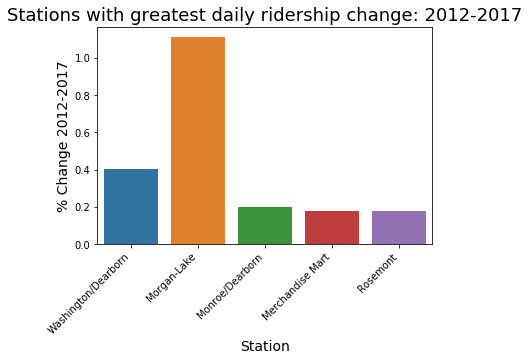

In [11]:
# Plot stations with biggest percent change in daily ridership from 2012 to 2017
fig, ax = plt.subplots()
sns.barplot(x='stationname', y='5yr_percent_diff', data=top, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Stations with greatest daily ridership change: 2012-2017', fontsize=18)
ax.set_xlabel('Station', fontsize=14)
ax.set_ylabel('% Change 2012-2017', fontsize=14)

In [12]:
# get average daily ridership yearly change for the past 5 years
df_yrdiff=pd.DataFrame()
years_list_5 = np.arange(2017, 2011, -1)
df_yrdiff = df[df['year'].isin(years_list_5)]
df_yrdiff = df_yrdiff.groupby(['stationname','year'])['rides'].mean().reset_index()

# get rid of stations w/ missing data in 2012 or 2017
df_yrdiff = df_yrdiff.groupby('stationname').filter(lambda x: len(x) >5)

# # find change in ridership in past 5 years
df_yrdiff['5yr_diff_ave'] = df_yrdiff['rides'].diff()
df_yrdiff['5yr_percent_diff_ave'] = df_yrdiff['rides'].pct_change()
df_yrdiff = df_yrdiff[df_yrdiff['year']!= 2012]
df_yrdiff=df_yrdiff.groupby('stationname').mean().reset_index()
df_yrdiff['years']=str(years_list_5[0])+'-'+str(years_list_5[-1])

In [13]:
# get 25 stations with biggest ridership change from 5 years ago
topdiffs_ave = df_yrdiff.sort_values(by=['5yr_diff_ave'], ascending=False).reset_index(drop=True).loc[0:24,:]
topprops_ave = df_yrdiff.sort_values(by=['5yr_percent_diff_ave'], ascending=False).reset_index(drop=True).loc[0:24,:]
top_ave = topdiffs_ave[topdiffs_ave['stationname'].isin(topprops['stationname'])]
topstationlist_ave = top_ave.stationname.unique()

In [14]:
df['is_topstation_ave']=df['stationname'].isin(topstationlist_ave)

Text(0, 0.5, 'Average % Change 2012-2017')

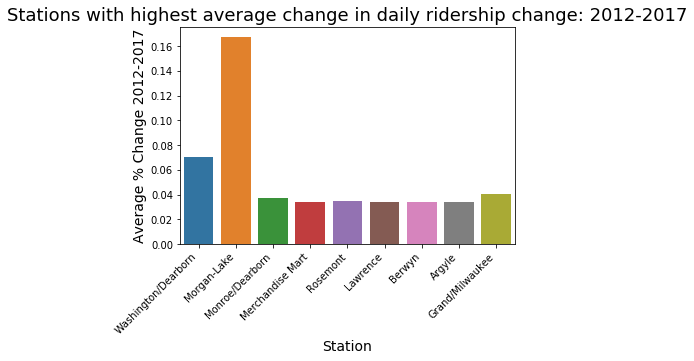

In [15]:
# Plot stations with biggest yearly average percent change 
# in daily ridership from 2012 to 2017
fig, ax = plt.subplots()
sns.barplot(x='stationname', y='5yr_percent_diff_ave', data=top_ave, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Stations with highest average change in daily ridership change: 2012-2017', 
          fontsize=18)
ax.set_xlabel('Station', fontsize=14)
ax.set_ylabel('Average % Change 2012-2017', fontsize=14)

In [16]:
# plot ridership over time
def make_time_plot(df, station):    
    d = df[df['stationname']==station]
    x = 'datetime'
    y = 'rides'
    a=d[x]
    b=d[y]
    fig, ax = plt.subplots()
    ax.plot(a, b)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title(station)

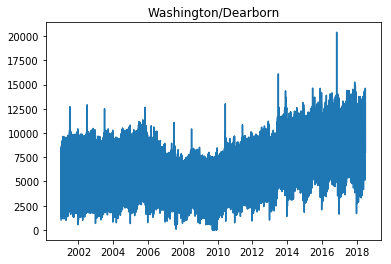

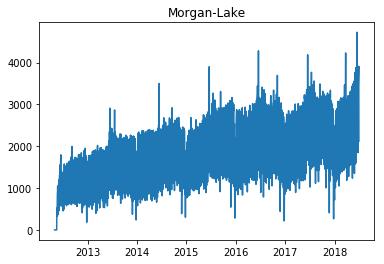

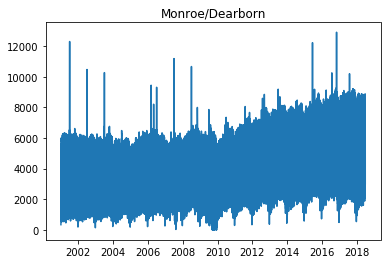

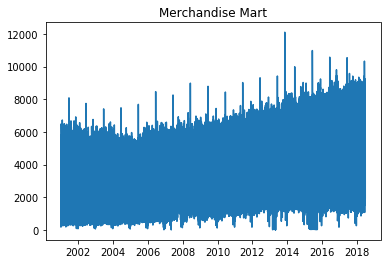

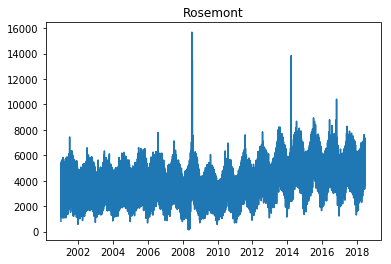

In [17]:
# plots stations with big changes from 2012 to 2017
for stat in topstationlist:
    make_time_plot(df, stat)

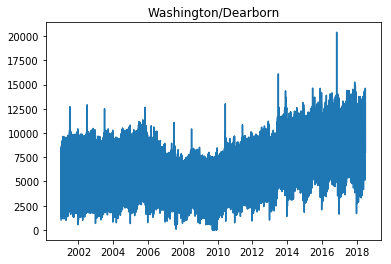

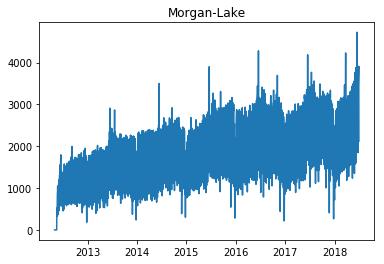

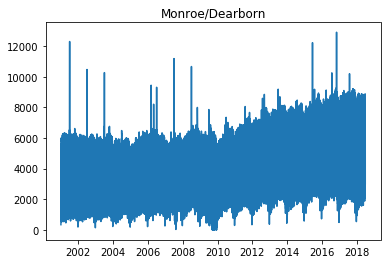

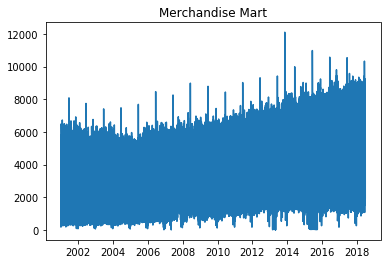

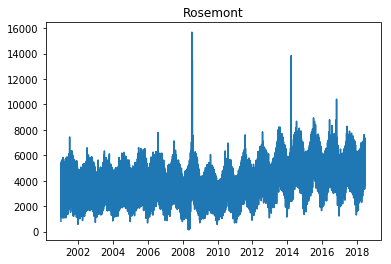

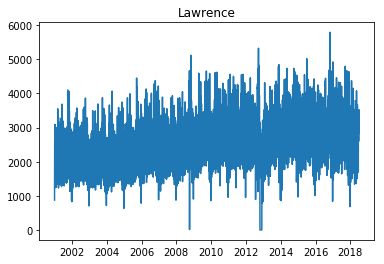

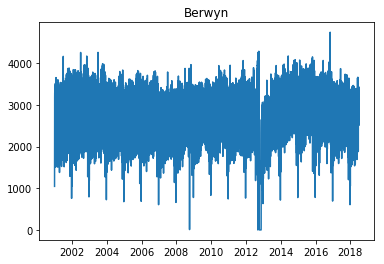

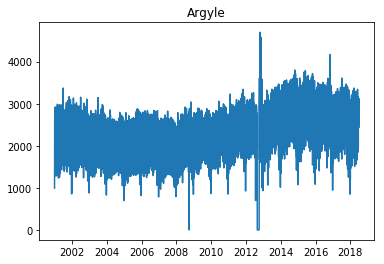

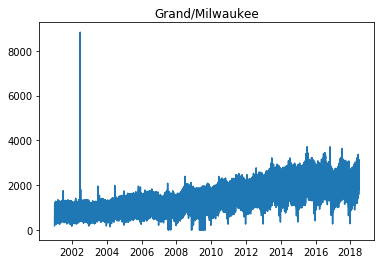

In [18]:
# plots stations with greatest average yearly increases between 2012 and 2017
for stat in topstationlist_ave:
    make_time_plot(df, stat)

In [19]:
y=pd.DataFrame(df.groupby(by=['stationname'])['rides'].mean())
y.loc[y.idxmax()]

,rides
stationname,
Clark/Lake,13900.595838


In [20]:
df_map = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops.csv')
loc_string = df_map[df_map['STATION_NAME']=='Morse'].reset_index().loc[0,'Location']
lat,long = loc_string.strip('()').split(',')

In [21]:
lats = []
lons = []
for val in df_map.Location:
    lat, long = val.strip('()').split(',')
    lats.append(float(lat))
    lons.append(float(long))
df_map['latitude']=lats  
df_map['longitude']=lons  

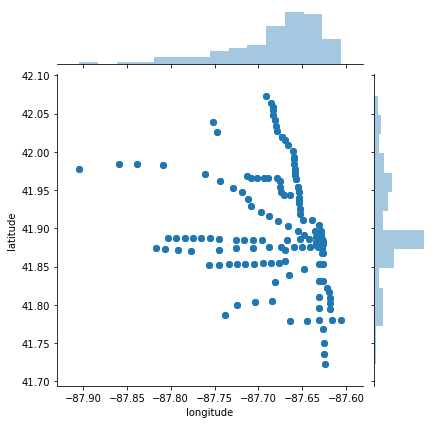

In [22]:
sns.jointplot(x="longitude",y="latitude", data=df_map)